<a href="https://colab.research.google.com/github/Amphibian27/Natural-Language-Processing/blob/master/Topic_Modeling_Thematic_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore',category = DeprecationWarning)
warnings.filterwarnings('ignore',category = UserWarning)
warnings.filterwarnings('ignore',category = FutureWarning)

In [39]:
import os
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
import spacy
import gensim
import gensim.corpora as corpora
from gensim import models
import pyLDAvis
import pyLDAvis.gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')
from nltk import PorterStemmer


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
df = pd.read_csv(r'Usecase3_Dataset.csv', encoding = 'latin1')

In [8]:
print(len(df))
print(df[:5])

14640
  airline_sentiment  ...                                               text
0           neutral  ...                @VirginAmerica What @dhepburn said.
1          positive  ...  @VirginAmerica plus you've added commercials t...
2           neutral  ...  @VirginAmerica I didn't today... Must mean I n...
3          negative  ...  @VirginAmerica it's really aggressive to blast...
4          negative  ...  @VirginAmerica and it's a really big bad thing...

[5 rows x 3 columns]


In [18]:
#Removing handles
df['cleaned_text'] = df["text"].apply(lambda row: re.sub(r'@[^\s]+','',row))

In [19]:
#Remove all links
df['cleaned_text'] = df["cleaned_text"].apply(lambda row: re.sub(r'http[s]?://\S+', '',str(row)))
df['cleaned_text'][7]

' Really missed a prime opportunity for Men Without Hats parody, there. '

In [20]:
#Remove special characters excluding apostrophe
df['cleaned_text'] = df["cleaned_text"].apply(lambda row: re.sub(r"[^A-Za-z0-9']+", ' ',row))
df['cleaned_text'][27]

" do you miss me Don't worry we'll be together very soon "

In [21]:
#remove leading and trailing blanks
df['cleaned_text'] = df["cleaned_text"].apply(lambda row: row.strip(' '))
df['cleaned_text'][27]

"do you miss me Don't worry we'll be together very soon"

### Lemmatization

In [43]:
def lemmatize_stemming(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [44]:
processed_docs = df['cleaned_text'].map(preprocess)
processed_docs[:10]

0                                                [say]
1          [plus, add, commercials, experience, tacky]
2                            [today, mean, need, trip]
3    [aggressive, blast, obnoxious, entertainment, ...
4                                              [thing]
5          [seriously, flight, seat, play, thing, fly]
6                           [nearly, time, worm, away]
7              [miss, prime, opportunity, hat, parody]
8                                                   []
9                   [amaze, arrive, hour, early, good]
Name: cleaned_text, dtype: object

In [45]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 say
1 add
2 commercials
3 experience
4 plus
5 tacky
6 mean
7 need
8 today
9 trip
10 aggressive


In [46]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [47]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(36, 1), (37, 1), (146, 1), (370, 1), (420, 1), (498, 1)]

In [49]:
bow_doc_2210 = bow_corpus[2210]
for i in range(len(bow_doc_2210)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_2210[i][0], 
                                               dictionary[bow_doc_2210[i][0]], 
bow_doc_2210[i][1]))

Word 12 ("flight") appears 1 time.
Word 24 ("hour") appears 1 time.
Word 91 ("hours") appears 1 time.
Word 169 ("plane") appears 1 time.
Word 202 ("point") appears 1 time.
Word 249 ("nonstop") appears 1 time.
Word 574 ("truly") appears 1 time.
Word 694 ("incompetence") appears 1 time.


In [50]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 1.0)]


In [83]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=8, id2word=dictionary, passes=2, workers=2)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [84]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.049*"flight" + 0.042*"thank" + 0.020*"number" + 0.017*"great" + 0.016*"good" + 0.015*"seat" + 0.013*"tell" + 0.012*"know" + 0.011*"check" + 0.010*"airlines"
Topic: 1 
Words: 0.059*"service" + 0.050*"flight" + 0.043*"customer" + 0.019*"email" + 0.018*"thank" + 0.015*"plane" + 0.014*"people" + 0.013*"seat" + 0.011*"upgrade" + 0.010*"customers"
Topic: 2 
Words: 0.068*"flight" + 0.040*"cancel" + 0.029*"flightled" + 0.028*"try" + 0.027*"hours" + 0.024*"hold" + 0.021*"phone" + 0.020*"help" + 0.018*"need" + 0.018*"guy"
Topic: 3 
Words: 0.031*"delay" + 0.025*"airline" + 0.024*"flight" + 0.022*"gate" + 0.020*"leave" + 0.019*"sit" + 0.016*"plan" + 0.015*"say" + 0.015*"follow" + 0.014*"worst"
Topic: 4 
Words: 0.165*"flight" + 0.046*"cancel" + 0.027*"delay" + 0.022*"late" + 0.016*"flightled" + 0.016*"plane" + 0.014*"miss" + 0.014*"book" + 0.014*"hours" + 0.012*"wait"
Topic: 5 
Words: 0.032*"service" + 0.028*"wait" + 0.026*"hold" + 0.026*"customer" + 0.016*"minutes" + 0.014*"send

In [85]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=8, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

Topic: 0 Word: 0.021*"flight" + 0.013*"cancel" + 0.011*"luggage" + 0.011*"try" + 0.011*"worst" + 0.011*"airline" + 0.010*"help" + 0.010*"want" + 0.010*"tell" + 0.010*"hours"
Topic: 1 Word: 0.019*"wait" + 0.018*"flight" + 0.016*"hours" + 0.013*"answer" + 0.012*"plane" + 0.012*"hold" + 0.010*"time" + 0.010*"airport" + 0.010*"like" + 0.009*"late"
Topic: 2 Word: 0.022*"need" + 0.018*"flight" + 0.016*"love" + 0.016*"great" + 0.015*"thank" + 0.014*"follow" + 0.013*"guy" + 0.011*"help" + 0.009*"fly" + 0.009*"plane"
Topic: 3 Word: 0.034*"flight" + 0.017*"cancel" + 0.014*"thank" + 0.012*"say" + 0.012*"wait" + 0.011*"service" + 0.010*"flightled" + 0.009*"think" + 0.009*"customer" + 0.009*"best"
Topic: 4 Word: 0.064*"thank" + 0.022*"flight" + 0.014*"time" + 0.013*"gate" + 0.012*"help" + 0.012*"customer" + 0.012*"service" + 0.011*"cancel" + 0.009*"fleek" + 0.009*"fleet"
Topic: 5 Word: 0.026*"flight" + 0.021*"delay" + 0.014*"miss" + 0.013*"go" + 0.012*"good" + 0.011*"hour" + 0.010*"tell" + 0.010*"t

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [86]:
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.8748225569725037	 
Topic: 0.054*"time" + 0.035*"help" + 0.026*"flight" + 0.015*"fly" + 0.015*"like" + 0.014*"thank" + 0.014*"work" + 0.013*"delay" + 0.013*"lose" + 0.013*"look"

Score: 0.017904845997691154	 
Topic: 0.072*"thank" + 0.055*"flight" + 0.027*"need" + 0.024*"help" + 0.024*"change" + 0.023*"today" + 0.019*"go" + 0.016*"want" + 0.014*"wait" + 0.013*"ticket"

Score: 0.01789909601211548	 
Topic: 0.049*"flight" + 0.042*"thank" + 0.020*"number" + 0.017*"great" + 0.016*"good" + 0.015*"seat" + 0.013*"tell" + 0.012*"know" + 0.011*"check" + 0.010*"airlines"

Score: 0.01788155362010002	 
Topic: 0.032*"service" + 0.028*"wait" + 0.026*"hold" + 0.026*"customer" + 0.016*"minutes" + 0.014*"send" + 0.013*"tell" + 0.012*"take" + 0.012*"baggage" + 0.011*"airport"

Score: 0.017878243699669838	 
Topic: 0.165*"flight" + 0.046*"cancel" + 0.027*"delay" + 0.022*"late" + 0.016*"flightled" + 0.016*"plane" + 0.014*"miss" + 0.014*"book" + 0.014*"hours" + 0.012*"wait"

Score: 0.0178731456398963

In [87]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.49838921427726746	 
Topic: 0.034*"flight" + 0.017*"cancel" + 0.014*"thank" + 0.012*"say" + 0.012*"wait" + 0.011*"service" + 0.010*"flightled" + 0.009*"think" + 0.009*"customer" + 0.009*"best"

Score: 0.3942655324935913	 
Topic: 0.022*"need" + 0.018*"flight" + 0.016*"love" + 0.016*"great" + 0.015*"thank" + 0.014*"follow" + 0.013*"guy" + 0.011*"help" + 0.009*"fly" + 0.009*"plane"

Score: 0.017908267676830292	 
Topic: 0.064*"thank" + 0.022*"flight" + 0.014*"time" + 0.013*"gate" + 0.012*"help" + 0.012*"customer" + 0.012*"service" + 0.011*"cancel" + 0.009*"fleek" + 0.009*"fleet"

Score: 0.017902150750160217	 
Topic: 0.019*"flight" + 0.014*"check" + 0.013*"service" + 0.011*"look" + 0.010*"today" + 0.010*"delay" + 0.009*"thank" + 0.009*"customer" + 0.008*"know" + 0.008*"leave"

Score: 0.01788843423128128	 
Topic: 0.021*"flight" + 0.013*"cancel" + 0.011*"luggage" + 0.011*"try" + 0.011*"worst" + 0.011*"airline" + 0.010*"help" + 0.010*"want" + 0.010*"tell" + 0.010*"hours"

Score: 0.017

In [88]:
vis = pyLDAvis.gensim.prepare(lda_model_tfidf, bow_corpus, dictionary)

In [89]:
lda_model.show_topics()

[(0,
  '0.049*"flight" + 0.042*"thank" + 0.020*"number" + 0.017*"great" + 0.016*"good" + 0.015*"seat" + 0.013*"tell" + 0.012*"know" + 0.011*"check" + 0.010*"airlines"'),
 (1,
  '0.059*"service" + 0.050*"flight" + 0.043*"customer" + 0.019*"email" + 0.018*"thank" + 0.015*"plane" + 0.014*"people" + 0.013*"seat" + 0.011*"upgrade" + 0.010*"customers"'),
 (2,
  '0.068*"flight" + 0.040*"cancel" + 0.029*"flightled" + 0.028*"try" + 0.027*"hours" + 0.024*"hold" + 0.021*"phone" + 0.020*"help" + 0.018*"need" + 0.018*"guy"'),
 (3,
  '0.031*"delay" + 0.025*"airline" + 0.024*"flight" + 0.022*"gate" + 0.020*"leave" + 0.019*"sit" + 0.016*"plan" + 0.015*"say" + 0.015*"follow" + 0.014*"worst"'),
 (4,
  '0.165*"flight" + 0.046*"cancel" + 0.027*"delay" + 0.022*"late" + 0.016*"flightled" + 0.016*"plane" + 0.014*"miss" + 0.014*"book" + 0.014*"hours" + 0.012*"wait"'),
 (5,
  '0.032*"service" + 0.028*"wait" + 0.026*"hold" + 0.026*"customer" + 0.016*"minutes" + 0.014*"send" + 0.013*"tell" + 0.012*"take" + 0.012

In [90]:
pyLDAvis.display(vis)

### Key themes

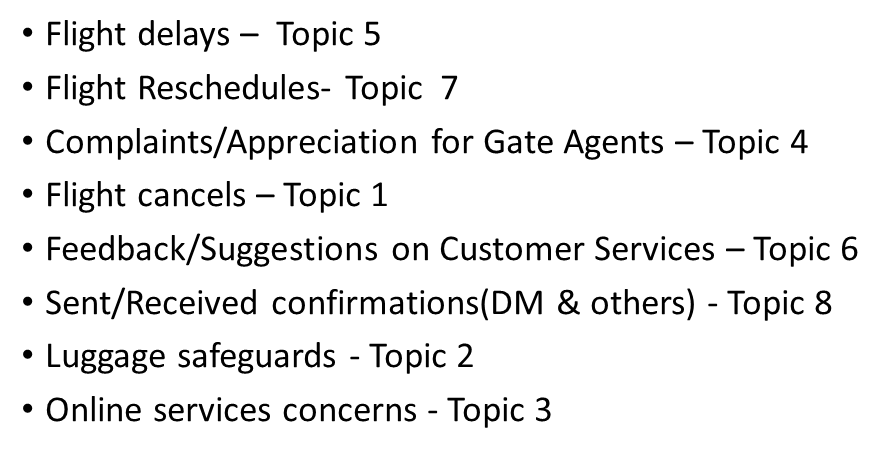